# Roadtrip Route Optimizer: Data-Driven Landmark Exploration

Our project focuses on creating a dynamic road trip experience by mapping out a route that passes through some of the most scenic and popular landmarks and natural attractions. We use real-world data—like the number of photos shared and reviews posted—to rank each stop and recommend how much time travelers might want to spend at each location.

The experience comes together with an interactive map and scrollable landmark cards, giving users a visual way to explore their trip. Each landmark is paired with photos and descriptions that bring it to life. We’ve also made it easy to sort or filter stops based on popularity, type of attraction—like nature spots or architectural sites—or the amount of time needed for a visit.

At the end, users get a full trip summary, showing the total distance they’ll cover and the number of landmarks included in their adventure.

In [379]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import time

import itertools
import math

from geopy.geocoders import Nominatim

from IPython.display import FileLink, display

## 1. Introduction into the Dataset and Data Preparation

For this project, we manually collected data on well-known landmarks across the United States by conducting web searches on platforms like Google. The dataset originally contained nine columns, capturing details such as city, state, landmark name, latitude, longitude, landmark type, estimated visit time, average user rating, number of reviews or photos, and annual visitor counts. However, for the purpose of this sightseeing route optimization project, we narrowed our focus to five nationally recognizable landmarks. This decision allowed us to build a model that could thoroughly analyze a manageable set of high-profile destinations while keeping computational efficiency in mind.

To prepare the data for analysis, we standardized the dataset for consistency and usability. All string values were converted to lowercase, and we replaced whitespaces and slashes with underscores to ensure uniform formatting across column names and data entries. Beyond basic cleaning, we engineered a new feature called the "popularity score" — a weighted metric that summarizes average user ratings, the volume of reviews or photos, and annual visitor numbers. This score provided a single value to help rank landmarks in terms of visitor interest and relevance, serving as a key factor in both our analysis and route optimization.

The final cleaned and feature-engineered dataset gave us a solid foundation for building models that analyze travel distances, landmark popularity, and optimal sightseeing routes, all designed to enhance both the technical and practical aspects of travel planning.

In [203]:
# Link to read the data in Sabrina's branch
url = 'https://raw.githubusercontent.com/KRMalaGrino/butterfly-brigade/refs/heads/sabrina/data_science/Landmark_Dataset_with_Visit_Time_and_Popularity_Factors.csv'
df = pd.read_csv(url)

In [204]:
# View the data 
df

,City,State,Landmark,Latitude,Longitude,Type,Visit Time (hrs),Average User Rating,Reviews/Photos,Annual Visitors
0,Keystone,South Dakota,Mount Rushmore,43.8791,-103.4591,Historical/Architectural,2,4.7,25000,2000000
1,Grand Canyon Village,Arizona,Grand Canyon,36.1069,-112.1129,Natural,8,4.9,60000,6000000
2,Niagara Falls,New York,Niagara Falls,43.0962,-79.0377,Natural,4,4.8,55000,9000000
3,New York,New York,Statue of Liberty,40.6892,-74.0445,Historical/Architectural,4,4.7,30000,4300000
4,St. Louis,Missouri,Gateway Arch,38.6247,-90.1848,Architectural,2,4.7,15000,2000000
5,Washington,District of Columbia,Lincoln Memorial,38.8893,-77.0502,Historical,1,4.8,25000,8000000
6,San Francisco,California,Golden Gate Bridge,37.8199,-122.4783,Architectural,2,4.8,45000,10000000
7,Orlando,Florida,Disney World,28.3852,-81.5639,Amusement Park,8,4.7,85000,58000000
8,Las Vegas,Nevada,Las Vegas Sphere,36.1699,-115.1398,Architectural/Entertainment,2,4.6,10000,3000000


In [205]:
# Reduce  list to only 5 locations and reset the index
df = df.drop(index=[1, 2, 5, 8], errors='ignore').reset_index(drop=True)

In [206]:
# Check the changes
df

,City,State,Landmark,Latitude,Longitude,Type,Visit Time (hrs),Average User Rating,Reviews/Photos,Annual Visitors
0,Keystone,South Dakota,Mount Rushmore,43.8791,-103.4591,Historical/Architectural,2,4.7,25000,2000000
1,New York,New York,Statue of Liberty,40.6892,-74.0445,Historical/Architectural,4,4.7,30000,4300000
2,St. Louis,Missouri,Gateway Arch,38.6247,-90.1848,Architectural,2,4.7,15000,2000000
3,San Francisco,California,Golden Gate Bridge,37.8199,-122.4783,Architectural,2,4.8,45000,10000000
4,Orlando,Florida,Disney World,28.3852,-81.5639,Amusement Park,8,4.7,85000,58000000


In [207]:
# Get an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   City                 5 non-null      object 
 1   State                5 non-null      object 
 2   Landmark             5 non-null      object 
 3   Latitude             5 non-null      float64
 4   Longitude            5 non-null      float64
 5   Type                 5 non-null      object 
 6   Visit Time (hrs)     5 non-null      int64  
 7   Average User Rating  5 non-null      float64
 8   Reviews/Photos       5 non-null      int64  
 9   Annual Visitors      5 non-null      int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 532.0+ bytes


In [208]:
# Lower case the columns and fill whitespace with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

In [209]:
# Check changes
df.columns

Index(['city', 'state', 'landmark', 'latitude', 'longitude', 'type',
       'visit_time_(hrs)', 'average_user_rating', 'reviews_photos',
       'annual_visitors'],
      dtype='object')

In [210]:
# Lowercase the values, replace whitespace and / with an underscore
df = df.map(lambda x: x.lower().replace(' ', '_').replace('/', '_') if isinstance(x, str) else x)

In [211]:
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000


### 1.1 Feature Engineering

To summarize the average_user_rating, review_photos and annual_vistors, we are creating an additional feature to score overall 'popularity' for each landmark.

In [214]:
# Set the weights to value the degree of importance of each of the columns
w_r = 0.40 # weight for the ratings
w_p = 0.30 # weight for the reviews_photos
w_v = 0.30 # weight for the visitors

In [215]:
# Calculate max values 
max_reviews = df['reviews_photos'].max()
max_visitors = df['annual_visitors'].max()

In [216]:
# Feature engineering to score popularity out of 100
df['rating_factor'] = (df['average_user_rating'] / 5) * 100
df['reviews_factor'] = (df['reviews_photos'] / max_reviews) * 100
df['visitors_factor'] = (df['annual_visitors'] / max_visitors) * 100

In [217]:
# Calculate Popularity Score
df['popularity'] = (
    (df['rating_factor'] * w_r) +
    (df['reviews_factor'] * w_p) +
    (df['visitors_factor'] * w_v)
)

In [218]:
# Check changes
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors,rating_factor,reviews_factor,visitors_factor,popularity
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000,94.0,29.411765,3.448276,47.458012
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000,94.0,35.294118,7.413793,50.412373
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000,94.0,17.647059,3.448276,43.928600
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000,96.0,52.941176,17.241379,59.454767
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000,94.0,100.000000,100.000000,97.600000


In [219]:
# Round the 'popularity' score up to a whole number and change the type to integer
df['popularity'] = df['popularity'].round(0).astype(int)
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors,rating_factor,reviews_factor,visitors_factor,popularity
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000,94.0,29.411765,3.448276,47
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000,94.0,35.294118,7.413793,50
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000,94.0,17.647059,3.448276,44
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000,96.0,52.941176,17.241379,59
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000,94.0,100.000000,100.000000,98


Prepare a clean dataset thats downloadable for the software engineers.

In [221]:
landmarks = df.copy()

In [222]:
# Remove multiple columns
landmarks = landmarks.drop(columns=['average_user_rating', 'reviews_photos', 'annual_visitors', 'rating_factor', 'reviews_factor', 'visitors_factor'])

In [223]:
# Lower case the columns and fill whitespace with underscore
landmarks.columns = landmarks.columns.str.replace('_', ' ')

In [224]:
# Replace underscore with whitespace
landmarks = landmarks.map(lambda x: x.replace('_', ' ') if isinstance(x, str) else x)

In [225]:
landmarks

,city,state,landmark,latitude,longitude,type,visit time (hrs),popularity
0,keystone,south dakota,mount rushmore,43.8791,-103.4591,historical architectural,2,47
1,new york,new york,statue of liberty,40.6892,-74.0445,historical architectural,4,50
2,st. louis,missouri,gateway arch,38.6247,-90.1848,architectural,2,44
3,san francisco,california,golden gate bridge,37.8199,-122.4783,architectural,2,59
4,orlando,florida,disney world,28.3852,-81.5639,amusement park,8,98


In [226]:
# Save to CSV
landmarks.to_csv('landmarks.csv', index=False)

# Display download link
display(FileLink('landmarks.csv'))

/Users/sabrinamcfield/Desktop/DSprojects/butterfly-brigade/data_science/landmarks.csv

### 1.2 Filtering by Preferences

This function allows the user to pass any combination of filters — if they skip one, it simply won’t be applied.

In [358]:
def filter_landmarks(df, landmark_type=None, min_popularity=None, max_visit_time=None):
    """
    Filters the landmarks DataFrame based on any combination of:
    - landmark_type (exact match, case-insensitive)
    - minimum popularity score
    - maximum visit time in hours
    
    Users can pass one, two, or all three filters. If a filter is not provided, it will be ignored.
    
    Parameters:
        df (DataFrame): The landmarks DataFrame.
        landmark_type (str, optional): Type of landmark to filter by.
        min_popularity (float, optional): Minimum popularity score.
        max_visit_time (float, optional): Maximum visit time in hours.
    
    Returns:
        DataFrame: The filtered DataFrame.
    """
    filtered_df = landmarks.copy()
    
    if landmark_type:
        filtered_df = filtered_df[filtered_df['type'].str.lower() == landmark_type.lower()]
    
    if min_popularity is not None:
        filtered_df = filtered_df[filtered_df['popularity'] >= min_popularity]
    
    if max_visit_time is not None:
        filtered_df = filtered_df[filtered_df['visit time (hrs)'] <= max_visit_time]
    
    return filtered_df.reset_index(drop=True)

### 1.2.1 Examples

In [361]:
# Filter by type only
filter_landmarks(landmarks, landmark_type='architectural')

,city,state,landmark,latitude,longitude,type,visit time (hrs),popularity
0,st. louis,missouri,gateway arch,38.6247,-90.1848,architectural,2,44
1,san francisco,california,golden gate bridge,37.8199,-122.4783,architectural,2,59


In [363]:
# Filter by popularity only
filter_landmarks(landmarks, min_popularity=70)

,city,state,landmark,latitude,longitude,type,visit time (hrs),popularity
0,orlando,florida,disney world,28.3852,-81.5639,amusement park,8,98


In [365]:
# Filter by visit time only
filter_landmarks(landmarks, max_visit_time=3)

,city,state,landmark,latitude,longitude,type,visit time (hrs),popularity
0,keystone,south dakota,mount rushmore,43.8791,-103.4591,historical architectural,2,47
1,st. louis,missouri,gateway arch,38.6247,-90.1848,architectural,2,44
2,san francisco,california,golden gate bridge,37.8199,-122.4783,architectural,2,59


In [373]:
# Filter by type and popularity
filter_landmarks(landmarks, landmark_type='architectural', min_popularity=40)

,city,state,landmark,latitude,longitude,type,visit time (hrs),popularity
0,st. louis,missouri,gateway arch,38.6247,-90.1848,architectural,2,44
1,san francisco,california,golden gate bridge,37.8199,-122.4783,architectural,2,59


In [377]:
# Filter by all three
filter_landmarks(landmarks, landmark_type='amusement park', min_popularity=80, max_visit_time=8)

,city,state,landmark,latitude,longitude,type,visit time (hrs),popularity
0,orlando,florida,disney world,28.3852,-81.5639,amusement park,8,98


### 1.2 Exploratory Data Analysis Visualizations

The "Top 5 Popular Landmarks" visualization highlights the landmarks in order of popularity. The Disney World Amusement Park is the obvious winner in popularity, with the Golden Gate Bridge coming in second. The Gateway Arch is the least popular among the five destinations. The "Map Route For Visiting Popular Most Destinations in Order" helps visualize the route based on popularity in descending order. The "Visit Time vs. Popularity" plot helps visualize the route based on popularity, in descending order.

**1.2.1 Top 5 Popular Landmarks**

The “Top 5 Popular Landmarks” bar chart ranks the selected landmarks by their calculated popularity score. This visualization makes it easy to compare how each destination stands in relation to the others based on visitor interest and engagement. Disney World Amusement Park ranks as the most popular landmark by a significant margin, followed by the Golden Gate Bridge. The Gateway Arch ranks lowest among the five, indicating it may attract fewer visitors or generate less engagement online. This chart provides a straightforward way to assess which landmarks are likely to be the biggest attractions for travelers.

In [230]:
# Get the top 5 landmarks based on popularity score
top10 = df.sort_values(by='popularity', ascending=False).head(10)

# Create a bar chart
fig = px.bar(
    top10,
    x='landmark', # landmark names on x-axis
    y='popularity', # popularity score on y-axis
    color='popularity', # color code based on the score
    title='Top 5 Most Popular Landmarks (Score)',
    hover_data=['city', 'state', 'visit_time_(hrs)'], # show details on the hover
    text='popularity' # show scores as text on the bars
)

fig.update_layout(xaxis_tickangle=-45) # rotate text on x-axis

fig.show() # display the chart

# Save the figure as PNG
fig.write_image('top5landmarks.png')

**1.2.2 Map Route for Visiting Most Popular Destinations in Order**

The “Map Route for Visiting Most Popular Destinations in Order” presents a geographic visualization of the landmarks plotted on a map, connected in the order of their popularity from highest to lowest. By arranging the landmarks this way, the map helps illustrate how a traveler might plan a sightseeing route if they prioritized visiting the most popular destinations first. This visual not only shows the geographical spread of the landmarks but also offers insight into the practicality of a popularity-based travel route.

In [232]:
# Copy data 
map_df = df.copy()

# Sort based on popularity score
map_df = map_df.sort_values(by='popularity', ascending=False).reset_index(drop=True)

# Create mapbox scatter with lines
fig = go.Figure()

# Add route line to connect based off sorted popularity score
fig.add_trace(go.Scattermap(
    mode="lines+markers+text", # show lines, markers and text
    lon=map_df['longitude'], # longitude data
    lat=map_df['latitude'],  # latitude data
    text=map_df['landmark'] + '<br>Popularity: ' + map_df['popularity'].astype(str), # hover text
    marker={'size': 10}, # marker size for landmarks
    line={'width': 2}, # line width
    hoverinfo='text' # show text on hover only
))

# Map layout based on landmark coordinates
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=3,
    mapbox_center={"lat": map_df['latitude'].mean(), "lon": map_df['longitude'].mean()},
    title="Landmark Route Based on Popularity",
    height=600
)

fig.show() # show the interactive map

# Save the figure as PNG
fig.write_image('popular_route.png')

**1.2.3 Visit Time Vs. Popularity**

The “Visit Time vs. Popularity” scatter plot shows how long visitors typically spend at each landmark compared to its popularity score. Each bubble represents a landmark, positioned by visit time and popularity, with bubble size reflecting engagement factors like reviews and color indicating the landmark type—such as historical, architectural, or amusement park. This visualization highlights patterns in visitor behavior, showing how popularity and visit duration relate across different types of attractions and helping identify which landmarks attract significant attention despite shorter or longer visit times.

In [234]:
# Create a scatter plot to compare the relationship between visit time and popularity
fig = px.scatter(
    df,
    x='visit_time_(hrs)', # visit time on the x-axis
    y='popularity', # popularity score on the y-axis
    color='type', # color based on landmark type
    hover_name='landmark', # show landmark name on hover
    title='Visit Time vs Popularity Score', 
    size='reviews_photos', # bubble size represents number of reviews_photos
    size_max=20 # max size for the bubbles
)

fig.show()

# Save the figure as PNG
fig.write_image('visit_popular.png')

## 2. Modeling

### 2.1 Baseline Model

We started by creating an initial route where the next landmark was selected at random, ensuring that each location was visited only once. This route served as our baseline model, allowing us to calculate the total distance traveled without any optimization. The baseline distance provides a reference point for comparing the performance of our optimization algorithms.

To accurately measure the distance between landmarks, we manually implemented the haversine formula, which calculates the shortest distance between two points on the Earth's surface using latitude and longitude. This calculation was incorporated into our compute_total_distance function, making it a reusable component for assessing route lengths throughout the project.

In [238]:
# Shuffle the data 
baseline_route = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [239]:
# View the baseline route
baseline_route

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors,rating_factor,reviews_factor,visitors_factor,popularity
0,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000,94.0,35.294118,7.413793,50
1,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000,94.0,100.000000,100.000000,98
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000,94.0,17.647059,3.448276,44
3,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000,94.0,29.411765,3.448276,47
4,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000,96.0,52.941176,17.241379,59


In [240]:
# Create an empty list 
distance_list = []

# Loop through each pair of consecutive landmarks for the baseline route
for i in range(len(baseline_route) - 1):
    landmark_from = baseline_route.loc[i, 'landmark']
    landmark_to = baseline_route.loc[i + 1, 'landmark']
    
    loc1 = (baseline_route.loc[i, 'latitude'], baseline_route.loc[i, 'longitude'])
    loc2 = (baseline_route.loc[i + 1, 'latitude'], baseline_route.loc[i + 1, 'longitude'])
    
    distance_km = haversine(loc1, loc2)
    
    # Append results as a dictionary
    distance_list.append({
        'From': landmark_from,
        'To': landmark_to,
        'Distance (km)': round(distance_km, 2)
    })

# Convert the list to a DataFrame
baseline_distances_df = pd.DataFrame(distance_list)

# Display the DataFrame
baseline_distances_df

,From,To,Distance (km)
0,statue_of_liberty,disney_world,1530.22
1,disney_world,gateway_arch,1389.59
2,gateway_arch,mount_rushmore,1252.02
3,mount_rushmore,golden_gate_bridge,1730.68


Since we were having issues with pip, we created a distance function using Python’s math library so we could continue testing.

We also wrote a function called 'best_route' that takes a starting latitude and longitude, then finds the route with the shortest total distance by using the 'compute_total_distance' function we already built. The output shows both the shortest distance and the order of locations in the best route, including the starting and ending at a predetermined "home" location. 

In [242]:
# Manual harversine function
def distance(lat1, lon1, lat2, lon2):
    lat1r = lat1*((math.pi)/180) #converts lats and lons to radians for formula
    lat2r = lat2*((math.pi)/180)
    lon1r = lon1*((math.pi)/180)
    lon2r = lon2*((math.pi)/180)
    delta_lat = lat2r - lat1r
    delta_lon = lon2r - lon1r
    R = 6378
    hav = ((math.sin((delta_lat)/2))**2) + (math.cos(lat1r))*(math.cos(lat2r))*((math.sin((delta_lon)/2))**2)
    distance = 2*R*math.asin(hav**0.5)
    return distance

In [243]:
# Made with manual harversine function
def compute_total_distance(route_df):
    total_distance = 0  #initialize total distance

    # Loop through each pair of consecutive locations in the route
    for i in range(len(route_df) - 1):
        lat1 = route_df.loc[i, 'latitude']
        lon1 = route_df.loc[i, 'longitude'] # Get the coordinates for the current location
        lat2 = route_df.loc[i+1, 'latitude']
        lon2 = route_df.loc[i+1, 'longitude'] # Get the coordinates of the next location in the route
        total_distance += distance(lat1, lon1, lat2, lon2) # Calculate the distance between loc1 and loc2 using haversine formula
    return total_distance  # Return total accumulated distance for the route

In [244]:
# Calculate distance for the random baseline route
baseline_distance = compute_total_distance(baseline_route)

print(f"Baseline Random Route Total Distance: {baseline_distance:.2f} km")

Baseline Random Route Total Distance: 5908.99 km


### 2.2 Optimized Model

The next step is to create a method that improves the route by reducing the total distance traveled. Here, the total distance acts as the objective function, and our aim is to minimize it. We plan to build an algorithm that chooses each subsequent stop based on proximity, making sure every landmark is visited only once.

Once the optimization is complete, we will calculate the total distance of the optimized route and record the time required to generate it. To clearly show the impact of the optimization, both the original baseline route and the optimized route will be displayed side by side for comparison.

-------

The "best_route" function begins by accepting latitude and longitude coordinates and creates a single-row DataFrame that places those values in the appropriate columns, while the remaining fields are filled with placeholder data. This row acts as the designated starting location. A duplicate of this DataFrame is also prepared to represent the ending location.

To explore all possible travel routes, the function generates a list of every permutation of the landmarks' index positions from the main DataFrame. For each possible arrangement, a temporary route is created by reordering the landmarks according to the current permutation. This reordered DataFrame is placed between the starting and ending point DataFrames and combined into a single route with the index reset. The total travel distance for this combined route is then calculated using the compute_total_distance function.

After each distance is computed, it is compared against the currently recorded best distance, and if it is shorter, both the distance and the corresponding route are saved. The function keeps track of the optimal route by recording the landmark sequence in a clean, readable list. Once all permutations have been checked, the function returns the shortest distance found and the final ordered list of landmarks representing the most efficient route.

**Be aware that the longitudes for American locations are "West" direction. Therefore they should be negative values.**

In [248]:
# Function to calculate total distance and best route by latitude and longitude inputs
def best_route(lat, lon):
    best_dist = 1000000 #about half the earth's circumference
    best_route = None
    location_order = []
    cols = df.columns
    fill = [['home', 'home', 'home', lat, lon, 'home', 0, 0, 0, 0, 0, 0, 0, 0]]
    home = pd.DataFrame(data=fill, columns=cols)
    home2 = home.copy()
    permutations = list(itertools.permutations(df.index))
    for i, perm in enumerate(permutations):
        route = df.loc[list(perm)].reset_index(drop=True)
        complete_route = pd.concat([home, route, home2], axis='index').reset_index(drop=True)
        dist = compute_total_distance(complete_route)
        if dist < best_dist:
            best_dist = dist
            best_route = complete_route
    for p in best_route['landmark']:
        location_order.append(p)
    return f"Total Distance: {best_dist}, Best Route {location_order}"

In [249]:
start_time = time.time()

# Test locations
print(best_route(40.0061, -83.0283)) # Ohio State University

end_time = time.time()

elapsed_time = end_time - start_time
print(f"The model calculated the optimal route in {elapsed_time:.2f} seconds.")

Total Distance: 9841.965626634103, Best Route ['home', 'gateway_arch', 'mount_rushmore', 'golden_gate_bridge', 'disney_world', 'statue_of_liberty', 'home']
The model calculated the optimal route in 0.16 seconds.


In [250]:
start_time = time.time()

# Test locations
print(best_route(45.5152, -122.6784)) #Portland, Oregon

end_time = time.time()

elapsed_time = end_time - start_time
print(f"The model calculated the optimal route in {elapsed_time:.2f} seconds.")

Total Distance: 10493.58176190254, Best Route ['home', 'mount_rushmore', 'gateway_arch', 'statue_of_liberty', 'disney_world', 'golden_gate_bridge', 'home']
The model calculated the optimal route in 0.17 seconds.


In [251]:
start_time = time.time()

# Test locations
print(best_route(29.7601, -95.3701)) #Houston, Texas

end_time = time.time()

elapsed_time = end_time - start_time
print(f"The model calculated the optimal route in {elapsed_time:.2f} seconds.")

Total Distance: 9921.111202227685, Best Route ['home', 'golden_gate_bridge', 'mount_rushmore', 'gateway_arch', 'statue_of_liberty', 'disney_world', 'home']
The model calculated the optimal route in 0.17 seconds.


In [252]:
start_time = time.time()

# Test locations
print(best_route(34.0549, -118.2426)) #Los Angeles, California

end_time = time.time()

elapsed_time = end_time - start_time
print(f"The model calculated the optimal route in {elapsed_time:.2f} seconds.")

Total Distance: 10013.82989959652, Best Route ['home', 'golden_gate_bridge', 'mount_rushmore', 'gateway_arch', 'statue_of_liberty', 'disney_world', 'home']
The model calculated the optimal route in 0.16 seconds.


<div style="background-color: #d4edda; padding: 10px; border-left: 5px solid green;">
For an accurate comparision, we updated the baseline model to have the same 'home', starting and ending point, as the 'best_route' model.
</div>

In [254]:
# THIS CODE WILL BE EDITED TO HAVE A HOME STARTING AND ENDING POINT
# View the baseline route
baseline_route

# Create an empty list 
distance_list = []

# Loop through each pair of consecutive landmarks for the baseline route
for i in range(len(baseline_route) - 1):
    landmark_from = baseline_route.loc[i, 'landmark']
    landmark_to = baseline_route.loc[i + 1, 'landmark']
    
    loc1 = (baseline_route.loc[i, 'latitude'], baseline_route.loc[i, 'longitude'])
    loc2 = (baseline_route.loc[i + 1, 'latitude'], baseline_route.loc[i + 1, 'longitude'])
    
    distance_km = haversine(loc1, loc2)
    
    # Append results as a dictionary
    distance_list.append({
        'From': landmark_from,
        'To': landmark_to,
        'Distance (km)': round(distance_km, 2)
    })

# Convert the list to a DataFrame
baseline_distances_df = pd.DataFrame(distance_list)

# Display the DataFrame
baseline_distances_df

,From,To,Distance (km)
0,statue_of_liberty,disney_world,1530.22
1,disney_world,gateway_arch,1389.59
2,gateway_arch,mount_rushmore,1252.02
3,mount_rushmore,golden_gate_bridge,1730.68


To improve the model, we will add a geocoder converter that takes an address as input then converts it into latitude and longitude. Then, the function will convert the address into latitude and longitude and return the optimized route and total distance.

In [256]:
# Converts address to latitude & longitude using Geopy
def geocode_address(address):
    geolocator = Nominatim(user_agent="brute_force_route_optimizer")
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        raise ValueError(f"Address not found: {address}")

In [257]:
# Takes address as an input and outputs total distance and the best route based off the input
def best_route1(address, df): #input of latitude and longitude coordinates

    # FIRST, Geocode the input for the address
    lat, lon = geocode_address(address) 
    
    best_dist = 1000000 # a million for comparison
    best_route = None # setting a variable for best route
    location_order = [] # blank list to append to later for neatness
    
    cols = df.columns # acquiring columns from location dataframe

    # SECOND, create dataframe row for home/starting point
    fill = [['home', 'home', 'home', lat, lon, 'home', 0, 0, 0, 0, 0, 0, 0, 0]] #list of values for dataframe creation
    home = pd.DataFrame(data=fill, columns=cols) #home dataframe
    home2 = home.copy() #copy
    
    # THIRD, check all permutations of landmark order
    permutations = list(itertools.permutations(df.index)) #all permutations of index
    
    for i, perm in enumerate(permutations): # for loop to try all permutations with home location at start and finish
        route = df.loc[list(perm)].reset_index(drop=True) # new order of df
        complete_route = pd.concat([home, route, home2], axis='index').reset_index(drop=True) # concat
        dist = compute_total_distance(complete_route) # calculate total distance
        if dist < best_dist: # check if the distance is shorter
            best_dist = dist
            best_route = complete_route
    
    # FOURTH, extract order of landmark names for display
    for p in best_route['landmark']: # appending loactions for neatness
        location_order.append(p)
    
    return f"Total Distance: {best_dist}, Best Route {location_order}"

In [258]:
# Geocoder works best with street address, city and state at a minimum
address = '1417 Columbus Drive St. Louis Mo'

start_time = time.time()

result = best_route1(address, df)
print(result)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"The model calculated the optimal route in {elapsed_time:.2f} seconds.")

Total Distance: 9848.683985131469, Best Route ['home', 'gateway_arch', 'statue_of_liberty', 'disney_world', 'golden_gate_bridge', 'mount_rushmore', 'home']
The model calculated the optimal route in 1.27 seconds.


## 3. Visualizations

The visualizations for this project are designed to be interactive, allowing users to engage with the data through elements like hover pop-ups. These features help users explore location statistics, travel times, and route details more effectively. Using libraries such as Plotly, the visualizations will highlight key information, including a map that displays the landmarks and the optimized travel route. They will also show both the initial and optimized total distances, along with the time the model needed to calculate the best route, giving users a clear comparison of the model’s performance.

### 3.1 Baseline Route Visualization

This visualization presents the baseline route, featuring interactive pop-ups that appear when hovering over each landmark. The pop-ups display the landmark's name, the next destination in the route, and the distance between them.

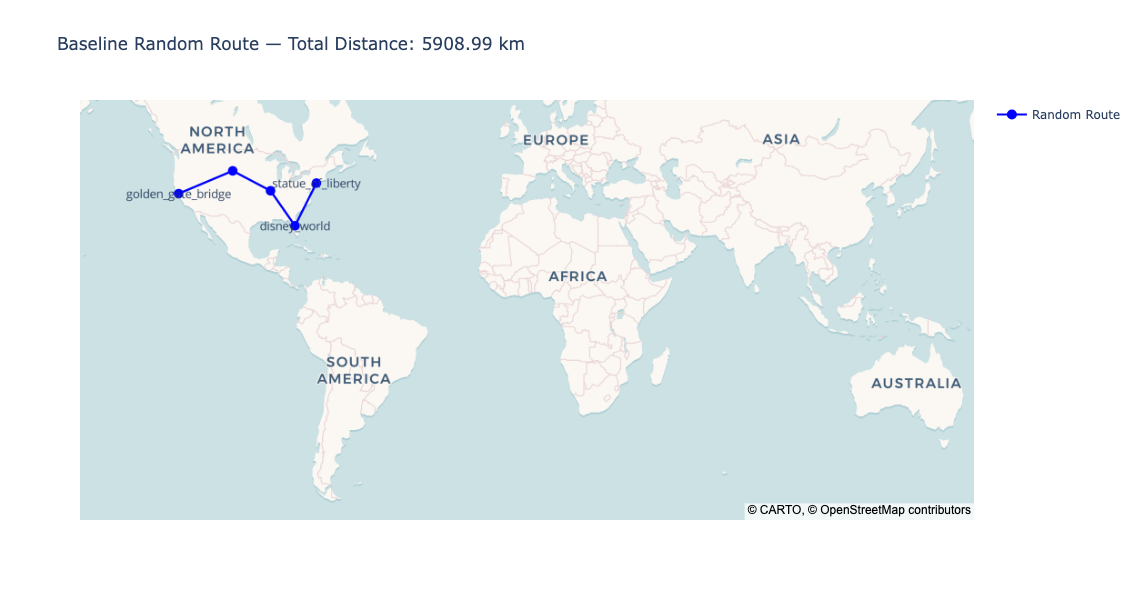

In [263]:
# Make a copy of the baseline route DataFrame 
route_map = baseline_route.copy()

# Initialize plotly figure
fig = go.Figure()

# Add a trace (layer) to the figure for the route line and markers
fig.add_trace(go.Scattermap(
    mode="lines+markers+text",  # Show lines connecting points, markers, and text labels
    lon=route_map['longitude'],  # Longitude values for the map points
    lat=route_map['latitude'],   # Latitude values for the map points
    text=route_map['landmark'],  # Landmark names appear on hover
    marker={'size': 10, 'color': 'blue'},  # Marker appearance 
    line={'width': 2, 'color': 'blue'},    # Line appearance 
    hoverinfo='text',  # Show text on hover
    name='Random Route'  # Legend name
))

# Add line segments with hover text showing the distance
for i in range(len(route_map) - 1):
    loc1 = (route_map.loc[i, 'latitude'], route_map.loc[i, 'longitude'])
    loc2 = (route_map.loc[i + 1, 'latitude'], route_map.loc[i + 1, 'longitude'])
    
    distance_km = haversine(loc1, loc2)
    
    fig.add_trace(go.Scattermap(
        mode="lines",
        lon=[loc1[1], loc2[1]],
        lat=[loc1[0], loc2[0]],
        line={'width': 2, 'color': 'blue'},
        text=[f"{route_map.loc[i, 'landmark']} → {route_map.loc[i + 1, 'landmark']}<br>Distance: {distance_km:.2f} km"],
        hoverinfo='text',
        showlegend=False
    ))

# Update the map layout
fig.update_layout(
    mapbox_style="open-street-map",  # The base map style
    mapbox_zoom=3,  # Set initial zoom level
    mapbox_center={  # Center the map based on average of all latitudes and longitudes
        "lat": route_map['latitude'].mean(),
        "lon": route_map['longitude'].mean()
    },
    title=f"Baseline Random Route — Total Distance: {baseline_distance:.2f} km",  # Title includes total distance
    height=600  # Set figure height
)

# Display the interactive map
fig.show()

# Save the figure as PNG
fig.write_image('baseline_route.png')

### 3.2 Optimized Route Visualization

This function calculates the optimized route by taking latitude and longitude coordinates of a predetermined starting and ending point called 'home'.  This function is the same as the best_route(lat,lon) function except it produces the output as a dataframe to be used solely for creating the visualization below. 

In [266]:
def best_route3(lat, lon):
    best_dist = 1000000 #about half the earth's circumference
    best_route = None
    location_order = []
    cols = df.columns
    fill = [['home', 'home', 'home', lat, lon, 'home', 0, 0, 0, 0, 0, 0, 0, 0]]
    home = pd.DataFrame(data=fill, columns=cols)
    home2 = home.copy()
    permutations = list(itertools.permutations(df.index))
    for i, perm in enumerate(permutations):
        route = df.loc[list(perm)].reset_index(drop=True)
        complete_route = pd.concat([home, route, home2], axis='index').reset_index(drop=True)
        dist = compute_total_distance(complete_route)
        if dist < best_dist:
            best_dist = dist
            best_route = complete_route
    return best_route

In [267]:
# Calculate the time the model needs to calculate the best route

start_time = time.time()

route_map = best_route3(40.0061, -83.0283)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"The model calculated the optimal route in {elapsed_time:.2f} seconds.")

The model calculated the optimal route in 0.16 seconds.


In [268]:
# Initialize plotly figure
fig = go.Figure()

# Add a trace (layer) to the figure for the route line and markers
fig.add_trace(go.Scattermap(
    mode="lines+markers+text",  # Show lines connecting points, markers, and text labels
    lon=route_map['longitude'],  # Longitude values for the map points
    lat=route_map['latitude'],   # Latitude values for the map points
    text=route_map['landmark'],  # Landmark names appear on hover
    marker={'size': 10, 'color': 'blue'},  # Marker appearance 
    line={'width': 2, 'color': 'blue'},    # Line appearance 
    hoverinfo='text',  # Show text on hover
    name='Route'  # Legend name
))

# Add line segments with hover text showing the distance
for i in range(len(route_map) - 1):
    lat1 = route_map.loc[i, 'latitude']
    lon1 = route_map.loc[i, 'longitude'] 
    lat2 = route_map.loc[i+1, 'latitude']
    lon2 = route_map.loc[i+1, 'longitude']
    
    distance_km = compute_total_distance(route_map)
    
    fig.add_trace(go.Scattermap(
        mode="lines",
        lon=[lon1, lon2],
        lat=[lat1, lat2],
        line={'width': 2, 'color': 'blue'},
        text=[f"{route_map.loc[i, 'landmark']} → {route_map.loc[i + 1, 'landmark']}<br>Distance: {distance_km:.2f} km"],
        hoverinfo='text',
        showlegend=False
    ))

# Update the map layout
fig.update_layout(
    mapbox_style="open-street-map",  # The base map style
    mapbox_zoom=3,  # Set initial zoom level
    mapbox_center={  # Center the map based on average of all latitudes and longitudes
        "lat": route_map['latitude'].mean(),
        "lon": route_map['longitude'].mean()
    },
    title=f"Optimized Route — Total Distance: {distance_km:.2f} km",  # Title includes total distance
    height=600  # Set figure height
)

# Display the interactive map
fig.show()

# Save the figure as PNG
fig.write_image('optimized_route.png')

### 3.3 Baseline vs. Optimized Route Visualization

In [270]:
#Visualization for baseline vs. optimized route that require a predetermined home starting and ending point

### 3.4 Optimized Route w/ Geocoder Visualization

This is the final function that requires an address as input and returns the best route with total distance, a list of the order of the landmarks based on the best route, and a visualization of the best route that includes a pop-up when hovering over each landmark. The pop-up includes the landmark name, type, visit time, popularity score, and the distance to the next destination.

In [273]:
def best_route_map(address, df):
    # Step 1 — Geocode address
    lat, lon = geocode_address(address)
    
    best_dist = float('inf')
    best_route_df = None
    
    cols = df.columns
    home_data = [['home', 'home', 'home', lat, lon, 'home', 0, 0, 0, 0, 0, 0, 0, 0]]
    home = pd.DataFrame(data=home_data, columns=cols)
    home2 = home.copy()
    
    # Step 2 — Brute-force all permutations
    permutations = list(itertools.permutations(df.index))
    for perm in permutations:
        route = df.loc[list(perm)].reset_index(drop=True)
        complete_route = pd.concat([home, route, home2], ignore_index=True)
        dist = compute_total_distance(complete_route)
        if dist < best_dist:
            best_dist = dist
            best_route_df = complete_route

    # Step 3 — Create hover text with next leg distance
    hover_texts = []
    for i in range(len(best_route_df)):
        row = best_route_df.loc[i]
        if i < len(best_route_df) - 1:
            loc1 = (row['latitude'], row['longitude'])
            loc2 = (best_route_df.loc[i + 1, 'latitude'], best_route_df.loc[i + 1, 'longitude'])
            next_leg_distance = haversine(loc1, loc2)
            next_leg_info = f"Next Leg Distance: {next_leg_distance:.2f} km"
        else:
            next_leg_info = "End of Route"
        
        hover_texts.append(
            f"<b>{row['landmark']}</b><br>"
            f"Type: {row['type']}<br>"
            f"Visit Time: {row['visit_time_(hrs)']} hrs<br>"
            f"Popularity Score: {row['popularity']}<br>"
            f"{next_leg_info}"
        )

    # Step 4 — Plotting with Plotly
    fig = go.Figure()

    # Add lines between landmarks with distance info
    for i in range(len(best_route_df) - 1):
        loc1 = (best_route_df.loc[i, 'latitude'], best_route_df.loc[i, 'longitude'])
        loc2 = (best_route_df.loc[i + 1, 'latitude'], best_route_df.loc[i + 1, 'longitude'])
        fig.add_trace(go.Scattermap(
            mode="lines",
            lon=[loc1[1], loc2[1]],
            lat=[loc1[0], loc2[0]],
            line={'width': 2, 'color': 'green'},
            text=[f"{best_route_df.loc[i, 'landmark']} → {best_route_df.loc[i + 1, 'landmark']}<br>Distance: {haversine(loc1, loc2):.2f} km"],
            hoverinfo='text',
            showlegend=False
        ))

       # Add markers with hover text
    fig.add_trace(go.Scattermap(
        mode="markers",  # Only markers, no always-visible text
        lon=best_route_df['longitude'],
        lat=best_route_df['latitude'],
        text=hover_texts,
        marker={'size': 10, 'color': 'green'},
        hoverinfo='text',
        name='Optimized Route'
    ))
    
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=4,
        mapbox_center={"lat": best_route_df['latitude'].mean(), "lon": best_route_df['longitude'].mean()},
        title=f"Optimized Route — Total Distance: {best_dist:.2f} km",
        height=600
    )

    fig.show()

    # Step 5 — Return route summary
    location_order = best_route_df['landmark'].tolist()
    return f"Total Distance: {best_dist:.2f} km, Best Route: {location_order}"
    

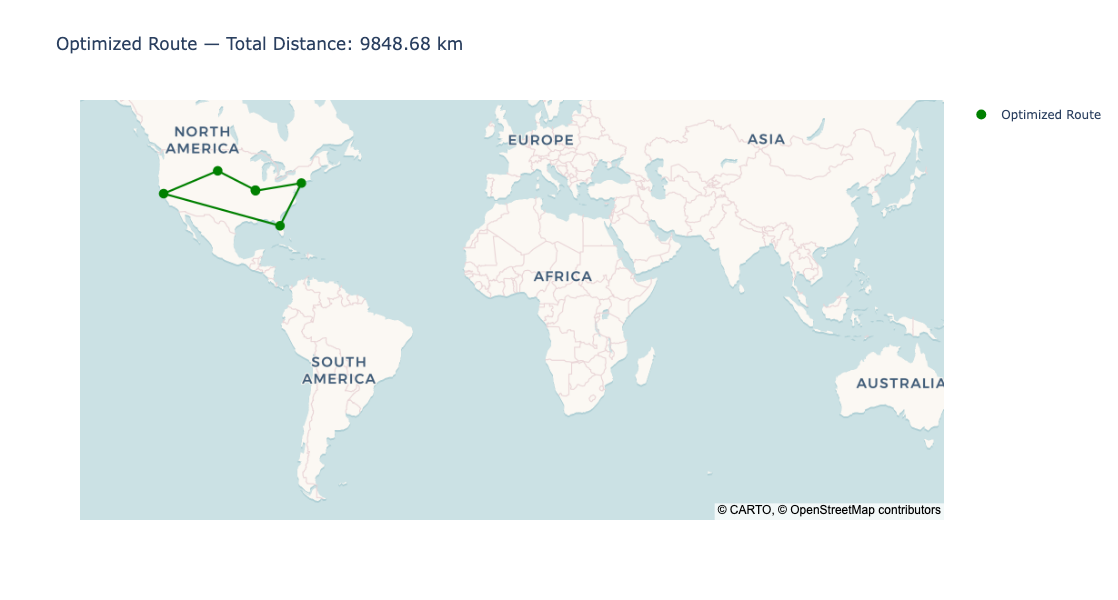

The model calculated the optimal route and produced a visualization in 1.23 seconds.


In [274]:
# Geocoder works best with street address, city and state at a minimum
address = '1417 Columbus Drive St. Louis Mo'

# Calculate the time the model needs to calculate the best route

start_time = time.time()

result = best_route_map(address, df)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"The model calculated the optimal route and produced a visualization in {elapsed_time:.2f} seconds.")

## Conclusion